In [1]:
import numpy as np
import pandas as pd
import random
import math
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import BTC_Cell_Line_Atlas_Manuscript.scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure7/output_fig7/'

from BTC_Cell_Line_Atlas_Manuscript.scripts.io_library import MyLib
from BTC_Cell_Line_Atlas_Manuscript.scripts.utils import Utils
from BTC_Cell_Line_Atlas_Manuscript.scripts.visualization import MyVisualization

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

In [3]:
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
gene_effect_df = gene_effect_df.T

genes_exclude_file = 'Additional_Data/Selected_Lists/all_common_genes.csv'
genes_exclude = MyLib.load_csv(genes_exclude_file)['Gene'].tolist()
gene_effect_df = gene_effect_df.loc[:, ~gene_effect_df.columns.isin(genes_exclude)]

upset_file = 'cell_lines_master_upset_2024-4-13.csv'
raw_upset_df = MyLib.load_csv(upset_file, index_col=0)
upset_df = raw_upset_df[(raw_upset_df['CRISPR']==1) & (raw_upset_df['Subtype']!='HCC')]
gene_effect_df =  gene_effect_df.loc[upset_df.index, :]

lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']].dropna(axis=0)
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])
lrt_df.set_index('gene', inplace=True, drop=True)
indices = sorted(set(lrt_df.index).intersection(set(gene_effect_df.columns)))
gene_effect_df = gene_effect_df[indices]
lrt_df = lrt_df.loc[indices,:]

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/Additional_Data/Selected_Lists/all_common_genes.csv  is loaded, shape:  (2577, 1)

input_data/cell_lines_master_upset_2024-4-13.csv  is loaded, shape:  (87, 10)

input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



In [4]:
lrt_df

,lrt,median,mean,skewed_left,name
gene,,,,,
A1CF (29974),6.864035,-0.061229,-0.065671,True,A1CF
A2M (2),1.799126,0.048005,0.035581,True,A2M
A3GALT2 (127550),0.000024,-0.058999,-0.067682,True,A3GALT2
AAAS (8086),12.887380,-0.120932,-0.178114,True,AAAS
AACS (65985),0.707311,-0.000419,-0.001628,True,AACS
...,...,...,...,...,...
ZXDA (7789),5.670228,0.014600,0.008205,True,ZXDA
ZXDB (158586),6.065673,0.121123,0.088698,True,ZXDB
ZYG11B (79699),0.738847,-0.193379,-0.208330,True,ZYG11B


In [5]:
def condition(column):
    return (column < -0.5).sum() >= 2

filtered_df = gene_effect_df.loc[:, gene_effect_df.apply(condition, axis=0)]
filtered_df.shape

(39, 1248)

In [6]:
results_df = pd.DataFrame(index=filtered_df.columns, columns=['Dependent Cell Lines', 'Dependent Cell Lines (%)', 'Dependent Cell Lines (fractions)', 'Dependent Cell Lines Median Gene Effect'], dtype='float64')
results_df['NormLRT'] = lrt_df.loc[filtered_df.columns, 'lrt']
for gene in filtered_df.columns:
    fractions = (filtered_df[gene] < -0.5).mean() 
    percentage = (filtered_df[gene] < -0.5).mean() * 100
    average = filtered_df.loc[(filtered_df[gene] < -0.5), gene].median()
    total = (filtered_df[gene] < -0.5).sum()

    results_df.loc[gene, 'Dependent Cell Lines'] = int(total)
    results_df.loc[gene, 'Dependent Cell Lines (%)'] = round(percentage)
    results_df.loc[gene, 'Dependent Cell Lines (fractions)'] = fractions
    results_df.loc[gene, 'Dependent Cell Lines Median Gene Effect'] = average


In [7]:
results_df

,Dependent Cell Lines,Dependent Cell Lines (%),Dependent Cell Lines (fractions),Dependent Cell Lines Median Gene Effect,NormLRT
Gene,,,,,
AAAS (8086),4.0,10.0,0.102564,-0.759003,12.887380
AARS2 (57505),8.0,21.0,0.205128,-0.568605,0.465015
ABCA4 (24),2.0,5.0,0.051282,-0.642254,3.948314
ABHD11 (83451),4.0,10.0,0.102564,-0.732569,7.270102
ABI1 (10006),8.0,21.0,0.205128,-0.587920,22.288772
...,...,...,...,...,...
ZSCAN18 (65982),2.0,5.0,0.051282,-0.514467,10.360088
ZSWIM8 (23053),3.0,8.0,0.076923,-0.508441,2.022947
ZW10 (9183),3.0,8.0,0.076923,-0.629180,0.074405


In [8]:
results_df.index = results_df.index.map(lambda x:x.split(' ')[0])
MyLib.save_csv(results_df, 'lrt_plot_genes.csv')
results_df


File  Figure7/output_fig7/lrt_plot_genes.csv saved, shape: (1248, 5)


,Dependent Cell Lines,Dependent Cell Lines (%),Dependent Cell Lines (fractions),Dependent Cell Lines Median Gene Effect,NormLRT
Gene,,,,,
AAAS,4.0,10.0,0.102564,-0.759003,12.887380
AARS2,8.0,21.0,0.205128,-0.568605,0.465015
ABCA4,2.0,5.0,0.051282,-0.642254,3.948314
ABHD11,4.0,10.0,0.102564,-0.732569,7.270102
ABI1,8.0,21.0,0.205128,-0.587920,22.288772
...,...,...,...,...,...
ZSCAN18,2.0,5.0,0.051282,-0.514467,10.360088
ZSWIM8,3.0,8.0,0.076923,-0.508441,2.022947
ZW10,3.0,8.0,0.076923,-0.629180,0.074405


In [9]:
pathways_dic = {'Vesicle Trafficking': ['SNAP23', 'STX4', 'STAMBP', 'STXBP3', 'IPPK'],
                 'Cell Polarity & Adhesion': ['CRKL', 'ELMO2', 'UXS1', 'ITGB5', 'ITGAV', 'PRKCI', 'PARD6B', 'DPM2', 'FERMT1', 'SLC33A1'],
                 'MAPK signaling': ['MAPK1', 'KRAS', 'MAP2K1' ,'BRAF', 'ERBB2', 'RAF1', 'FLOT1'],
                 'Cholesterol Biosynthesis': ['FDFT1', 'SREBF1', 'SQLE', 'PPARG', 'SREBF2'],
                 'Cell Cycle Regulation': ['MDM2', 'TP63', 'CCND3'],
                 'Folate Metabolism': ['TYMS', 'FPGS', 'MTR'],
                 'RNA Splicing':['SNRPB2','KHSRP'] }
pathways_colors_dic = {
                       'MAPK signaling': '#511849',
                       'Vesicle Trafficking': '#CA9B24',
                        'Cell Polarity & Adhesion': '#BF4040',
                       'Cholesterol Biosynthesis':'#3A7C29',
                       'Cell Cycle Regulation': '#E7763C',
                       'Folate Metabolism':'#16AECC',#'#0C7E7F',
                       'RNA Splicing':'#9D98FC'}

In [10]:
genes_l = ['SNRPB2', 'KHSRP', 'FDFT1', 'SREBF1', 'SQLE', 'PPARG', 'SREBF2', 'MDM2', 'TP63', 'CCND3', 'MAPK1', 'KRAS', 'MAP2K1', 'BRAF', 'ERBB2', 'RAF1', 'FLOT1', 'CRKL', 'ELMO2', 'UXS1', 'ITGB5', 'ITGAV', 'PRKCI', 'PARD6B', 'DPM2', 'FERMT1', 'SLC33A1', 'SNAP23', 'STX4', 'STAMBP', 'STXBP3', 'IPPK', 'TYMS', 'FPGS', 'MTR', 'CTNNB1', 'TGFBR1', 'PRKRA', 'KIF18B', 'HNF1B', 'PPCDC', 'NXT1', 'RBBP7', 'TIMM17A', 'TPK1', 'FBXL6', 'NMNAT1', 'SQSTM1', 'XPR1', 'SLC39A6']

In [11]:
colors_sr = pd.Series('#d4d4d4', index=results_df.index)#"#D9D9D9"
alpha_sr = pd.Series(0.6, index=results_df.index)#"#D9D9D9"
for p in pathways_dic:
    for g in pathways_dic[p]:
        if g in colors_sr.index:
            colors_sr[g] = pathways_colors_dic[p]
            alpha_sr[g] = 1

In [12]:
results_df.shape

(1248, 5)

saved LRT_pw.pdf


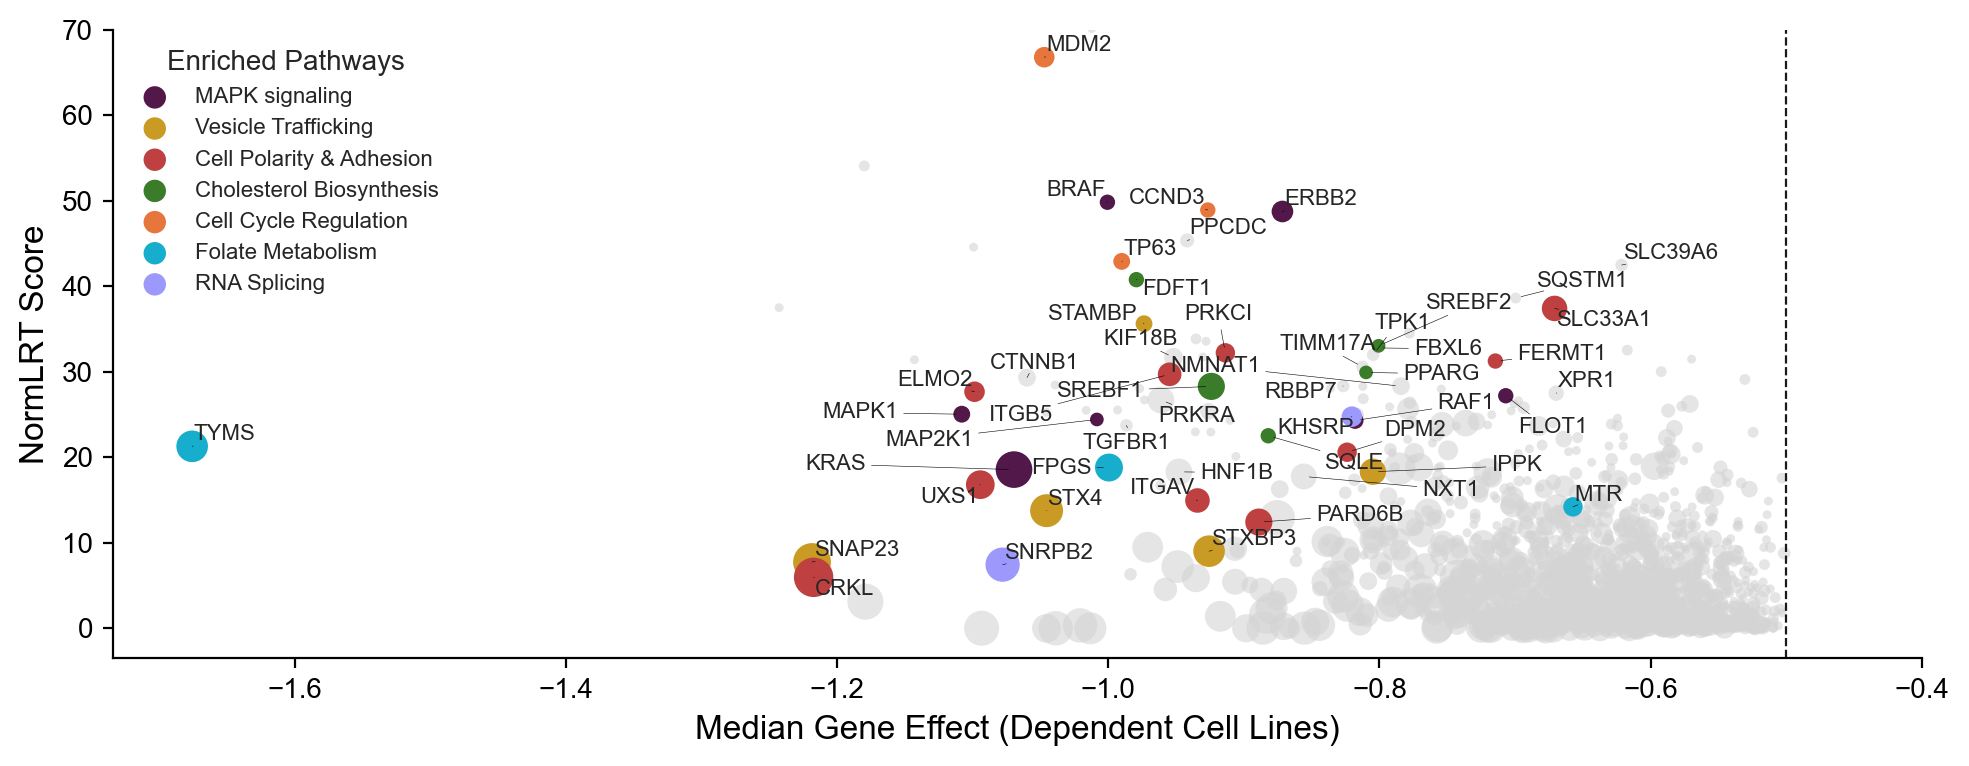

In [17]:
legend_title = 'Enriched Pathways'
MyVisualization.scatter_plot_comparison(X_data_sr=results_df['Dependent Cell Lines Median Gene Effect'], Y_data_sr=results_df['NormLRT'], points_size=results_df['Dependent Cell Lines (fractions)'], x_label= 'Median Gene Effect (Dependent Cell Lines)', colors_sr=colors_sr, y_label = 'NormLRT Score', title='', metric='', add_text=True, labels_text=genes_l, legend_classes_dic=pathways_colors_dic,  legend_label=legend_title, force_text=0.4, force_points=.3, alpha_points=alpha_sr, text_fontsize=8, size_scale=200, figure_width=10, ylim_top=70, legend_loc=True, xlim_right=-0.4, vline_x=-.5, save_file=True ,filename='LRT_pw')#, y_threshold=30, x_threshold=-0.5)

Retrieve the legend for point sizes.

In [18]:
results_df['Dependent Cell Lines (fractions)'].max()

0.8717948717948718

saved LRT_size.pdf


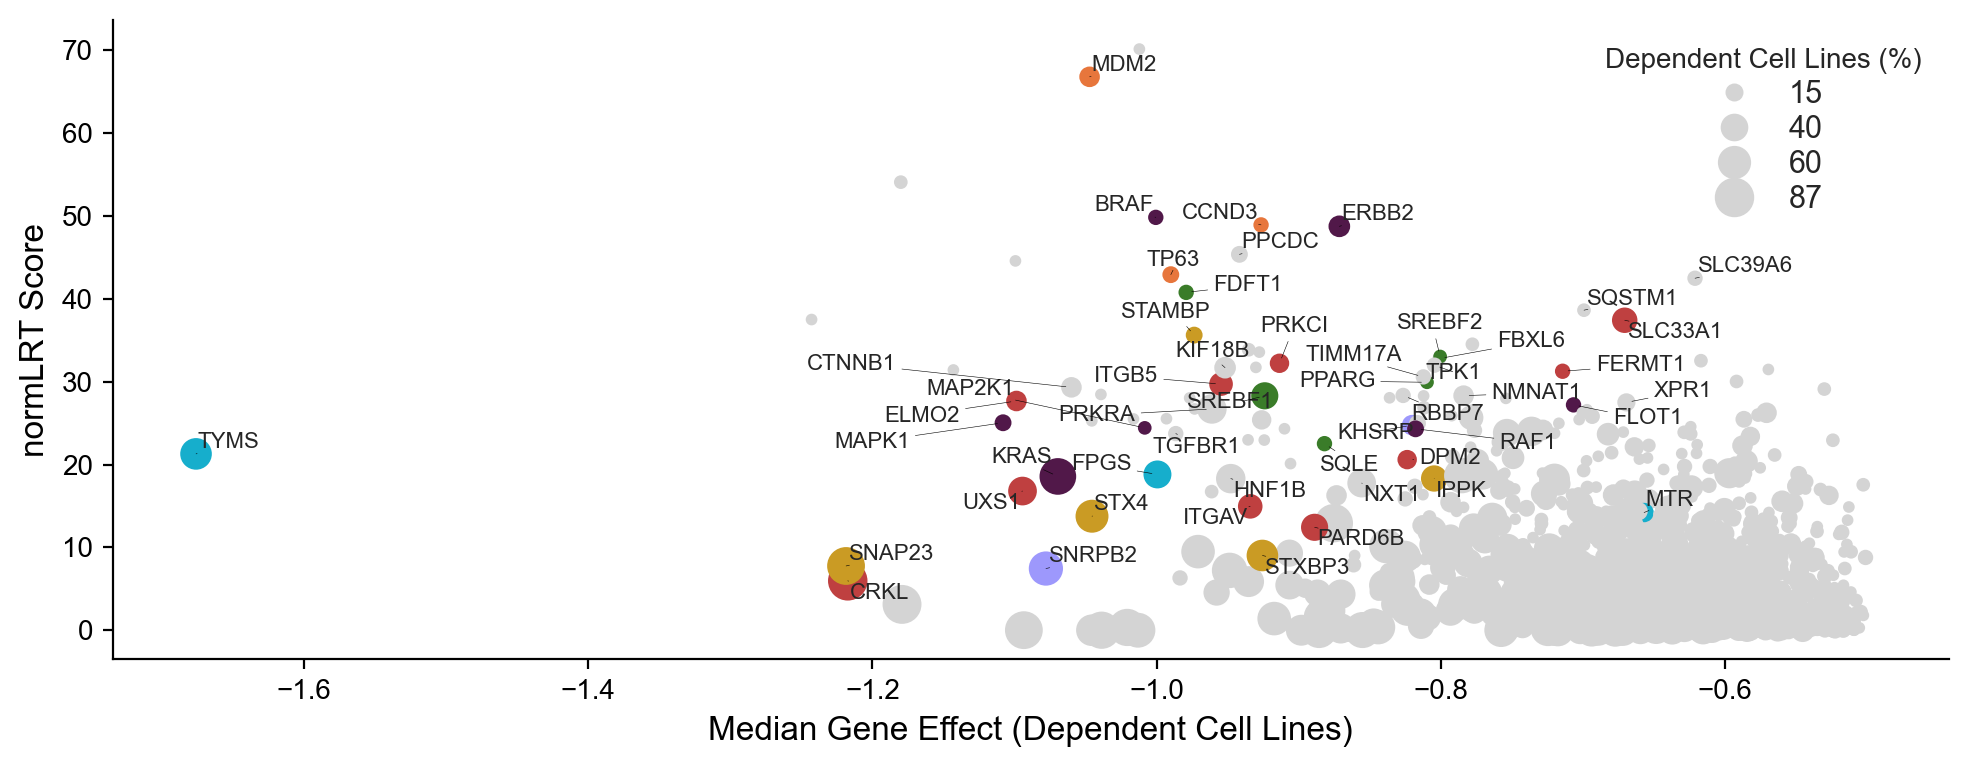

In [19]:
legend_title = 'Dependent Cell Lines (%)'
MyVisualization.scatter_plot_comparison(X_data_sr=results_df['Dependent Cell Lines Median Gene Effect'], Y_data_sr=results_df['NormLRT'], points_size=results_df['Dependent Cell Lines (fractions)'], size_scale=200, x_label= 'Median Gene Effect (Dependent Cell Lines)', colors_sr=colors_sr, y_label = 'normLRT Score', title='', metric='', add_text=True, legend_num=[15,40,60,87], labels_text=genes_l, alpha_points=1, legend_label=legend_title, force_text=0.4, force_points=.6, text_fontsize=8, figure_width=10, save_file=True, filename='LRT_size')